### construire et dessiner l'évolution de la T°C en FRANCE depuis 1800

> source: [ici](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByCountry.csv)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from time import time
rng = np.random.default_rng(seed=int(time()))
pd.__version__

URL="https://raw.githubusercontent.com/bandeDeCodeurs/dataviz_temperatures_france/main/GlobalLandTemperaturesByCountry.csv"
FINAL_URL="https://fr.wikipedia.org/wiki/Climat_de_la_France"

In [2]:
# téléchargement + écriture en local
pd.read_csv(
    URL,
).to_csv(
    "big_mean_global_temperature_1748_2013.csv",
    encoding="utf8",
    index=False
)

In [3]:
temp_df = pd.read_csv(
    "big_mean_global_temperature_1748_2013.csv",
    encoding="utf8",
    index_col="dt",
    parse_dates=True
)
# compléter les données d'une autre source
## read_html : trouver les <table> HTML dans une liste, chaque élément est converti en dataframe
# attention aux formats en terme de décimaux et milliers
wiki_df = pd.read_html(FINAL_URL, thousands=".",  decimal=",")[2]
temp_df
wiki_df


,Année,Moyenne annuelle,Janvier,Février,Mars,Avril,Mai,Juin,Juillet,Août,Septembre,Octobre,Novembre,Décembre
0,2023[a],14.4,6.3,6.9,10.2,11.8,16.2,21.5,21.9,22.0,21.1,16.4,10.1,8.0
1,2022[b],14.5,5.0,8.1,9.9,11.8,17.8,21.2,23.2,23.7,18.2,17.2,10.9,6.7
2,2021[c],12.9,4.9,8.2,8.9,10.4,13.8,20.3,20.7,20.0,19.3,13.5,7.9,6.9
3,2020[d],14.1,7.1,9.3,9.4,14.1,16.5,18.6,21.6,22.6,19.0,13.0,10.5,6.9
4,2019[e],13.7,4.6,8.0,10.1,11.7,13.9,20.1,23.0,21.8,18.5,15.1,8.8,8.1
5,2018[f],13.9,8.4,3.5,8.2,13.8,16.3,20.1,23.2,22.3,19.0,14.4,9.6,7.7
6,2017[g],13.4,3.1,8.2,11.0,11.4,16.5,21.2,21.7,21.5,16.4,14.9,8.2,5.9
7,2016[h],13.1,7.1,7.3,8.0,11.1,15.0,18.7,21.3,21.5,19.7,12.6,8.8,5.6
8,2015[i],13.6,5.6,4.9,9.1,12.6,15.5,19.8,22.8,21.6,16.4,12.7,11.2,9.5
9,2014[j],13.8,7.6,7.9,9.8,13.0,14.7,19.6,20.6,19.1,18.9,15.9,11.3,6.3


In [4]:
# temp_df["Country"].unique()
after_1800 = temp_df.index >= datetime.strptime("1800-01-01", "%Y-%m-%d")
temp_df = temp_df.loc[(after_1800) & (temp_df["Country"] == "France (Europe)")]
temp_df.drop(columns=["AverageTemperatureUncertainty", "Country"], inplace=True)
temp_df

,AverageTemperature
dt,
1800-01-01,3.914
1800-02-01,3.300
1800-03-01,4.582
1800-04-01,11.619
1800-05-01,14.931
...,...
2013-05-01,11.476
2013-06-01,16.328
2013-07-01,21.291


In [5]:
wiki_df = wiki_df.iloc[0:10, 0:2]
# wiki_df.drop(labels=wiki_df.index[10:]).drop(columns=wiki_df.columns[2:])

## remplacement vectorisé, utilisation de groupe de capture
# en oublie pas que le groupe n°0 c'est la regex elle même donc (\d{4}) es t le groupe n°1
# et on peut utiliser les références arrières en injectant le contenu d'un groupe ici \\1
wiki_df["Année"] = wiki_df["Année"].str.replace(pat="(\d{4})\[[a-z]\]", repl="\\1", regex=True)
# conversion en date
wiki_df["Année"] = pd.to_datetime(wiki_df["Année"], format="%Y")
wiki_df.set_index("Année", inplace=True)
wiki_df.sort_index(ascending=True, inplace=True)

wiki_df

,Moyenne annuelle
Année,
2014-01-01,13.8
2015-01-01,13.6
2016-01-01,13.1
2017-01-01,13.4
2018-01-01,13.9
2019-01-01,13.7
2020-01-01,14.1
2021-01-01,12.9
2022-01-01,14.5


In [6]:
# pb T° par mois VS T° par année : version artisanale
def get_temp_year(df: pd.DataFrame, ind):
    year = df.index[ind].year
    tmp_df = df[ind:ind+12].reset_index()
    # shift: décaler les données par rapport à l'index vers le haut < 0 et le bas > 0
    tmp_df["dt"] = tmp_df["dt"].diff().shift(-1)
    tmp_df["dt"] = tmp_df["dt"].dt.days.fillna(31.).astype("i2")
    t = round(tmp_df.apply(lambda r: r["dt"]*r["AverageTemperature"], axis=1).sum()/365, 2)
    return pd.DataFrame(data=[[year, t]])

container = []
for i in range(0, 212 * 12, 12):
    container.append(get_temp_year(temp_df, i))
pd.concat(container, axis=0)

,0,1
0,1800,10.70
0,1801,10.78
0,1802,10.77
0,1803,10.24
0,1804,10.76
...,...,...
0,2007,11.59
0,2008,11.25
0,2009,11.65
0,2010,10.57


In [7]:
# pb T° par mois VS T° par année : version magique
temp_df = temp_df.resample("Y", kind="period").mean().rename(columns={"AverageTemperature": "Moyenne annuelle"})
wiki_df.index = wiki_df.index.strftime("%Y")

In [8]:
complete_df = pd.concat([temp_df, wiki_df], axis=0)
complete_df["Moyenne annuelle"] = complete_df["Moyenne annuelle"].astype("float16")
del temp_df
del wiki_df


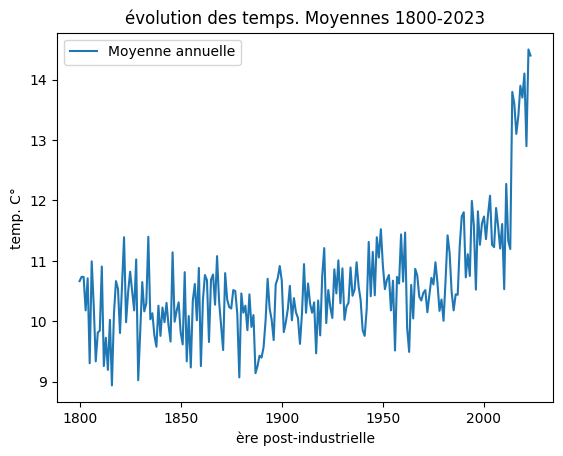

In [9]:
# graphe rapide depuis le dataframe
complete_df.plot(
    ylabel="temp. C°", 
    xlabel="ère post-industrielle",
    title="évolution des temps. Moyennes 1800-2023",
)
# facultatif dans jupyter
plt.savefig("evolution_temp.png")
plt.show()

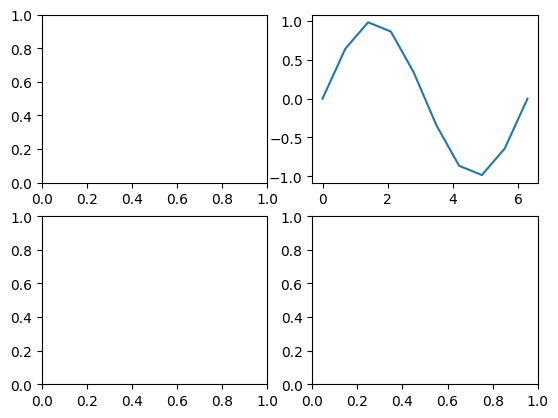

In [10]:
# créer une figure avec des graphes (subplots)
fig, axes = plt.subplots(2, 2)
axes[0][1].plot(np.linspace(0,2*np.pi, num=10), np.sin(np.linspace(0,2*np.pi, num=10)))


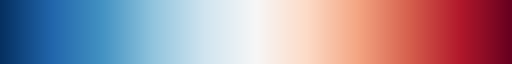

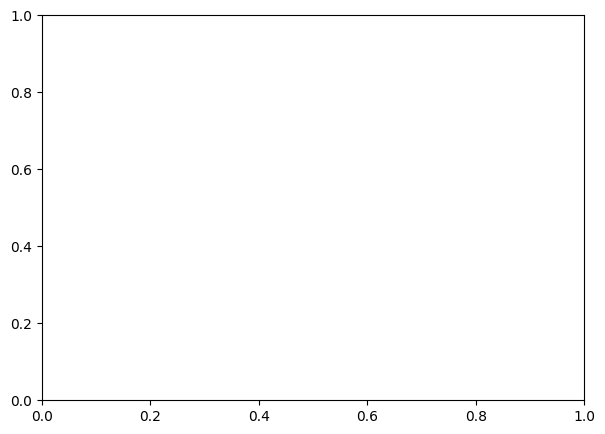

In [11]:
px = 1/plt.rcParams['figure.dpi']
width, height = 700, 500 
fig, ax = plt.subplots(
    figsize=(width*px, height*px)
)
# échelle de couleur
plt.get_cmap('RdBu_r')
#0                         0.5                                1

In [12]:
# correspondance entre le min de la temp Moyenne avec la carte de couleur
complete_df.describe()
x_interp = complete_df["Moyenne annuelle"].agg(["min", "mean", "max"]).tolist()
y_interp = [0., 0.5, 1.]

# interpolation
def getColor(temp):
    return np.interp(temp, x_interp, y_interp)

cmap = plt.get_cmap('RdBu_r')
# ffabrique le pigment particulier pour chaque température
cmap(getColor(complete_df["Moyenne annuelle"]))

array([[0.97093426, 0.95786236, 0.95017301, 1.        ],
       [0.9727797 , 0.94925029, 0.93540946, 1.        ],
       [0.9727797 , 0.94925029, 0.93540946, 1.        ],
       [0.76147636, 0.86851211, 0.92456747, 1.        ],
       [0.9727797 , 0.94925029, 0.93540946, 1.        ],
       [0.14248366, 0.41730104, 0.68335256, 1.        ],
       [0.9810842 , 0.91049596, 0.86897347, 1.        ],
       [0.81960784, 0.89803922, 0.94117647, 1.        ],
       [0.15294118, 0.43114187, 0.69042676, 1.        ],
       [0.45713187, 0.69950019, 0.83114187, 1.        ],
       [0.49357939, 0.72256824, 0.84359862, 1.        ],
       [0.97831603, 0.92341407, 0.8911188 , 1.        ],
       [0.12295271, 0.38754325, 0.65720877, 1.        ],
       [0.38423683, 0.65336409, 0.80622837, 1.        ],
       [0.10572857, 0.35432526, 0.61107266, 1.        ],
       [0.64521338, 0.8094579 , 0.89134948, 1.        ],
       [0.01960784, 0.18823529, 0.38039216, 1.        ],
       [0.72272203, 0.84882737,

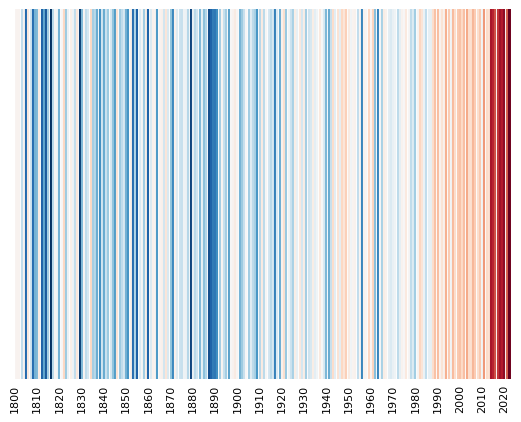

In [13]:
int_index = complete_df.index.astype("string").astype("i2")
plt.yticks(visible=False)
plt.xticks(int_index[::10], rotation=90, fontsize=8)
plt.box(False)
plt.margins(x=0,y=0)
plt.tick_params(axis="both", length=0)
# plt.title(label="évolution de la temp. Moyenne depuis 1800 à 2023")
# lignes verticales avec valeur en couleur
plt.vlines(
    x=int_index, 
    ymin=0, 
    ymax=height, 
    colors=cmap(getColor(complete_df["Moyenne annuelle"])))
